In [1]:
cd ..

/home/ikboljonsobirov/uncertainty-benchmark/experiments


In [2]:
import medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from models.models_mcd import ResNet18_MCD, ResNet50_MCD

from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter
from utils.utils import Transform3D, model_to_syncbn
from utils.ood_generators import add_gaussian_blur, add_gaussian_noise, increase_contrast, decrease_contrast
import os

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/231228_131656_resnet18mcd/best_model.pth'
# checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/nodulemnist3d/231228_122254_resnet18mcd/best_model.pth'

data_flag = 'organmnist3d'
# data_flag = 'nodulemnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
n_channels = info['n_channels']
n_classes = len(info['label'])

# load the data
train_dataset = DataClass(split='train',  download=download)
val_dataset = DataClass(split='val',  download=download)
test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/organmnist3d.npz


In [5]:
# # THIS IS FOR OOD DATA GENERATED AND STORED IN NUMPY ARRAYS IN LOCAL DIRECTORY

# # Assuming you have numpy arrays `features` and `labels`
# features = np.load('/home/ikboljonsobirov/uncertainty-benchmark/experiments/ood_data/organmnist3d/X_2_test.npy')
# labels = np.load('/home/ikboljonsobirov/uncertainty-benchmark/experiments/ood_data/organmnist3d/y_2_test.npy')

# # Convert numpy arrays to PyTorch Tensors
# features_tensor = torch.tensor(features)
# features_tensor = features_tensor.unsqueeze(1)
# labels_tensor = torch.tensor(labels)

# print(features_tensor.shape)
# print(labels_tensor.shape)
# # Create a TensorDataset
# dataset = TensorDataset(features_tensor, labels_tensor)

# # Create a DataLoader
# data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    total_output = 0
    
    with torch.no_grad():
        for i in range(num_samples):
            for data, _ in data_loader:
                data = data.to(device)
                output = model(data)
                total_output += output

    return total_output / num_samples

# Perform MC Dropout inference
model = ResNet18_MCD(in_channels=n_channels, num_classes=n_classes)
model = model_to_syncbn(ACSConverter(model))

model.to(device)
model = model.double()
model.load_state_dict(torch.load(checkpoint_path)['net'])

# mc_output = mc_dropout_inference(model, test_loader, num_samples=5)

<All keys matched successfully>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import torch.nn.functional as F


In [23]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    all_outputs = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            # data = add_gaussian_blur(data.squeeze().detach().cpu().numpy())
            # data = torch.from_numpy(data).unsqueeze(1).to(device)
            outputs = [model(data).detach().cpu().numpy() for _ in range(num_samples)]

            all_outputs.append(np.array(outputs))


    return all_outputs #np.mean(all_outputs, axis=0), np.std(all_outputs, axis=0)

# Perform MC Dropout inference
all_outputs = mc_dropout_inference(model, test_loader, num_samples=5)


In [24]:
# Concatenating along the second dimension
concatenated_output = np.concatenate(all_outputs, axis=1)
# apply softmax to the concatenated output
concatenated_output = F.softmax(torch.tensor(concatenated_output), dim=2)
# Checking the shape of the concatenated output
concatenated_output.shape


torch.Size([5, 610, 11])

In [25]:
mc_mean, mc_uncertainty = torch.mean(concatenated_output, axis=0), torch.std(concatenated_output, axis=0)

In [26]:
mc_mean[0]

tensor([3.3146e-04, 4.6533e-09, 3.4509e-08, 2.6879e-08, 3.7611e-05, 1.6116e-05,
        6.7913e-05, 1.8833e-07, 2.2361e-06, 5.7547e-05, 9.9949e-01],
       dtype=torch.float64)

In [27]:
mc_uncertainty[0]

tensor([1.9977e-04, 4.8723e-09, 5.0758e-08, 1.3990e-08, 1.8977e-05, 9.3005e-06,
        5.2086e-05, 1.3668e-07, 7.7490e-07, 3.7430e-05, 2.8789e-04],
       dtype=torch.float64)

In [28]:
targets = []
for _, target in test_loader:
    target = target.numpy()
    print(target.shape)
    targets.append(target)

(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(2, 1)


In [29]:
targets  = np.concatenate(targets, axis=0)

In [30]:
mc_mean.shape, targets.shape

(torch.Size([610, 11]), (610, 1))

In [31]:
total_f1 = f1_score(targets, np.argmax(mc_mean, axis=1), average='macro')
total_f1

0.946201978705581

In [32]:
# other metrics
total_acc = accuracy_score(targets, np.argmax(mc_mean, axis=1))
total_prec = precision_score(targets, np.argmax(mc_mean, axis=1), average='macro')
total_recall = recall_score(targets, np.argmax(mc_mean, axis=1), average='macro')
total_bal_acc = balanced_accuracy_score(targets, np.argmax(mc_mean, axis=1))
# total_auc = roc_auc_score(targets, mc_mean[:, 1], multi_class='ovo')
print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Balanced Accuracy: {:.4f}, F1: {:.4f}'.format(total_acc, total_prec, total_recall, total_bal_acc, total_f1))

Accuracy: 0.9361, Precision: 0.9483, Recall: 0.9451, Balanced Accuracy: 0.9451, F1: 0.9462


With add_guassian_blur

Accuracy: 0.9311, Precision: 0.9452, Recall: 0.9412, Balanced Accuracy: 0.9412, F1: 0.9427

0 0.001 0.9360655737704918
6 0.01108080808080808 0.9387417218543046
12 0.021161616161616163 0.9431438127090301
19 0.031242424242424245 0.949238578680203
25 0.041323232323232324 0.9521367521367521
31 0.0514040404040404 0.9550949913644214
37 0.06148484848484849 0.9616055846422339
43 0.07156565656565657 0.9647266313932981
49 0.08164646464646465 0.966131907308378
55 0.09172727272727273 0.9657657657657658
62 0.1018080808080808 0.9708029197080292
68 0.11188888888888888 0.9723247232472325
74 0.12196969696969698 0.9738805970149254
80 0.13205050505050506 0.9773584905660377
86 0.14213131313131314 0.9809160305343512
92 0.15221212121212122 0.9806949806949807
98 0.1622929292929293 0.982421875
105 0.17237373737373737 0.9821782178217822
111 0.18245454545454545 0.9819639278557114
117 0.19253535353535353 0.9878296146044625
123 0.2026161616161616 0.9897330595482546
129 0.2126969696969697 0.9896049896049897
135 0.22277777777777777 0.9894736842105263
142 0.23285858585858585 0.9893162393162394
148 0.242939

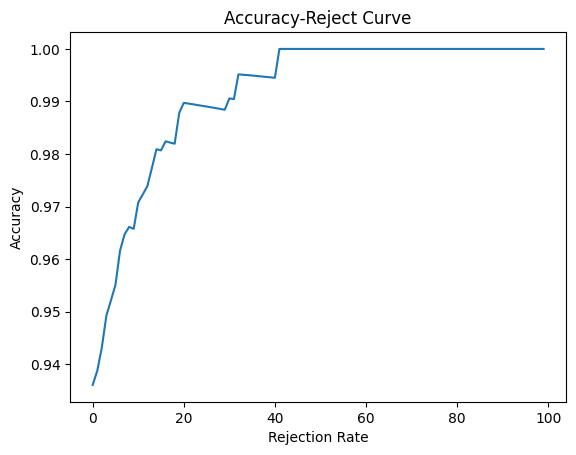

In [125]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    sorted_indices = np.argsort(predicted_class_uncertainty).numpy()[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [126]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    indices_to_keep = np.argsort(predicted_class_uncertainty).numpy()[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


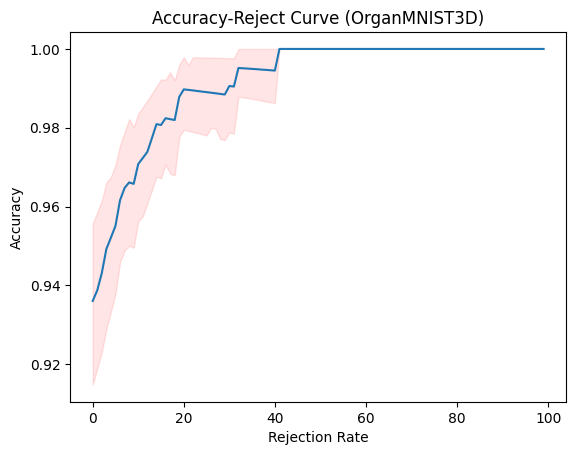

In [128]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


In [20]:
# lets get the area under this curve
from sklearn.metrics import auc
auc(rejection_rates, accuracies)

0.9904900811019584

### Use Entropy as the Uncertainty Metric

In [21]:
from scipy.stats import entropy

entropies = np.array([entropy(mean_prediction) for mean_prediction in mc_mean])
entropies.shape

(610,)

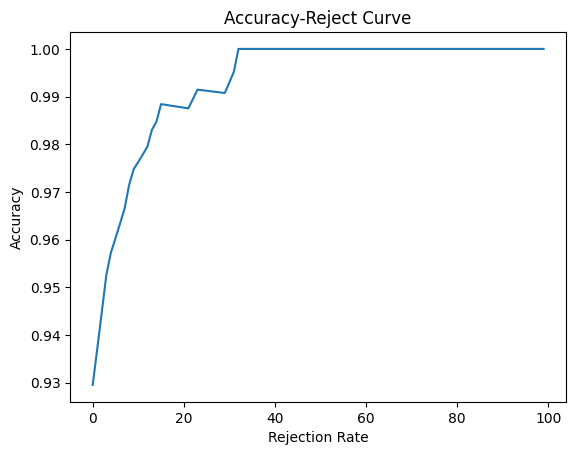

In [22]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
# predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.999, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(entropies) * rejection_rate)
    sorted_indices = np.argsort(entropies)[::-1]

    indices_to_keep = sorted_indices[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes.numpy()[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    # print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [23]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(entropies) * rejection_rate)
    indices_to_keep = np.argsort(entropies)[::-1][num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


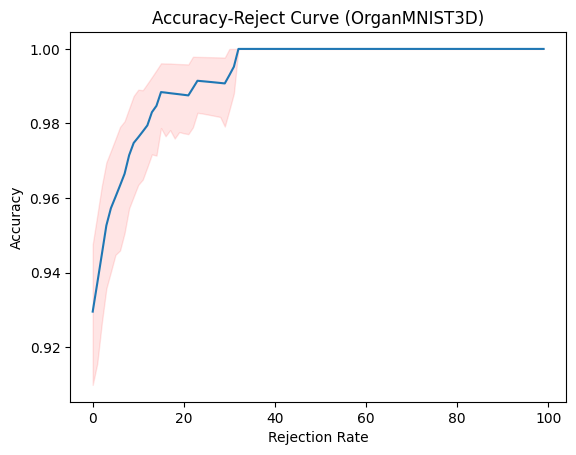

In [24]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()


### Use Confidence as the Uncertainty Metric

In [25]:
confidences = np.max(mc_mean.numpy(), axis=1)
confidences.shape

(610,)

609 0.001 0.9310344827586207
609 0.011070707070707071 0.9386401326699834
609 0.02114141414141414 0.9430485762144054
609 0.031212121212121212 0.9525423728813559
609 0.04128282828282828 0.9606164383561644
609 0.05135353535353535 0.9636678200692042
609 0.06142424242424242 0.9685314685314685
609 0.0714949494949495 0.9734982332155477
609 0.08156565656565656 0.9767857142857143
609 0.09163636363636363 0.9765342960288809
609 0.1017070707070707 0.9762340036563071
609 0.11177777777777778 0.9796672828096118
609 0.12184848484848484 0.9794392523364486
609 0.1319191919191919 0.9810964083175804
609 0.141989898989899 0.9866156787762906
609 0.15206060606060606 0.9864603481624759
609 0.16213131313131313 0.9882583170254403
609 0.1722020202020202 0.9880952380952381
609 0.18227272727272725 0.9879518072289156
609 0.19234343434343434 0.9878048780487805
609 0.2024141414141414 0.9876543209876543
609 0.21248484848484847 0.9895833333333334
609 0.22255555555555556 0.989451476793249
609 0.23262626262626263 0.98931

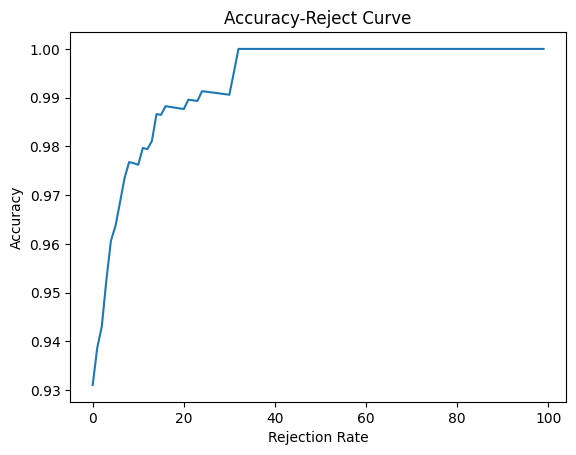

In [26]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
# predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.001, 0.998, 100)


for rejection_rate in rejection_rates:
    num_keep = int(len(confidences) * (1 - rejection_rate))
    indices_to_keep = np.argsort(confidences)[-num_keep:]

    # indices_to_keep = sorted_indices[num_keep:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = np.argmax(mc_mean, axis=1)[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)
    print(num_reject, rejection_rate, accuracy)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [27]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_keep = int(len(confidences) * (1 - rejection_rate))
    indices_to_keep = np.argsort(confidences)[-num_keep:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes.numpy()[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


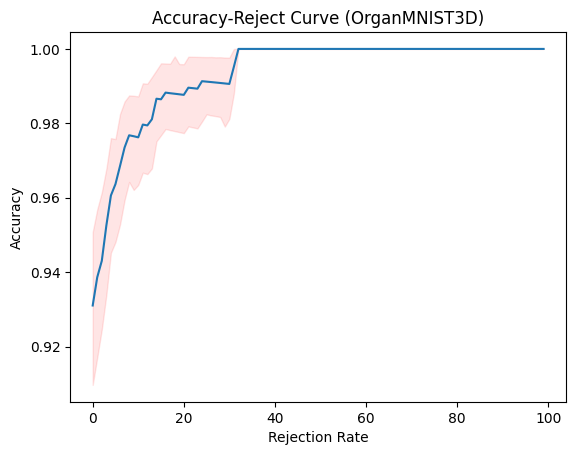

In [28]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (OrganMNIST3D)')
plt.show()
